# Project 2 - Singapore Housing Data and Kaggle Challenge

## Scenario

Singapore’s URA and HDB is monitoring the rise in HDB flat resale prices over the past few years, and is understandably concerned that some units are being priced out for a lot of buyers. 
They also are about to launch the HDB Resale Portal, which will allow HDB unit owners to list their flats on their own.

We - **JAKS Pte Ltd** - are a specialist consultant firm and have been asked by URA and HDB to to help them identify the factors and levers affecting a HDB unit’s price appreciation. 
This will help to:


1. Offer HDB unit owners pricing suggestions on the HDB Resale Portal


2. Plan for future developments as well as identify HDB estates for renewal and refurbishment plans in the future.

## Problem Statement

Based on given historical data of HDB resale prices and conditions prevalent at the time of resale, identify and present a data science model, which can accurately predict resale prices for HDB units, given the same criteria.

## Import statements

In [1]:
# Standard libraries for data loading and processing
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import geopandas as gpd
from shapely.geometry import shape, MultiPolygon, Polygon

# Other libraries
import warnings
import json
import geojson

# M/L libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

### Helper functions

This section contains a set of code, which we'll call regularly during our analysis.

In [2]:
def summarize_dataframe(df):
    summary = {
        'Column Name': [],
        'Unique Values': [],
        'Number of Unique Values': [],
        'Data Type': []
    }
    
    for column in df.columns:
        unique_values = df[column].unique()
        summary['Column Name'].append(column)
        summary['Unique Values'].append(unique_values)
        summary['Number of Unique Values'].append(len(unique_values))
        summary['Data Type'].append(df[column].dtype)
    
    summary_df = pd.DataFrame(summary)
    return summary_df

### Other misc code

In [3]:
pd.set_option('display.max_columns', None) # Allows us to see all columns within the notebook
pd.set_option('display.float_format', '{:,.2f}'.format) # Sets floats to only display upto 3 decimals
warnings.filterwarnings('ignore')

## Loading datasets and IDA

In [4]:
# Setting default low memory to False to allow loading large files
hdb_train_set = pd.read_csv('./datasets/train.csv', low_memory=False)
hdb_test_set = pd.read_csv('./datasets/test.csv', low_memory=False)

In [5]:
hdb_train_set.shape

(150634, 78)

In [6]:
hdb_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 78 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  Tranc_Year                 150634 non-null  int64  
 12  Tranc_Month                150634 non-null  int64  
 13  mid_storey                 15

In [7]:
hdb_train_set.head()

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,price_per_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,Latitude,Longitude,planning_area,Mall_Nearest_Distance,Mall_Within_500m,Mall_Within_1km,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_500m,Hawker_Within_1km,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.00,Model A,2006,"680,000.00",2016,5,11,10,12,11,4 ROOM Model A,"3B, UPP BOON KENG RD",968.76,701.93,15,25,2005,Y,N,N,N,N,142,0,0,0,96,46,0,0,0,0,0,0,0,382003,1.31,103.87,Kallang,"1,094.09",NaN,NaN,7.00,154.75,1.00,3.00,13.00,84,60,330.08,Kallang,0,0,1.31,103.87,29.43,Blk 3B,1.31,103.87,"1,138.63",Geylang Methodist School,78,1,1.32,103.88,"1,138.63",Geylang Methodist School,224,0,1.32,103.88
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.00,Improved,1987,"665,000.00",2012,7,8,7,9,8,5 ROOM Improved,"153, BISHAN ST 13","1,399.32",475.23,34,9,1987,Y,N,N,N,N,112,0,0,0,56,56,0,0,0,0,0,0,0,570153,1.35,103.86,Bishan,866.94,NaN,1.00,3.00,640.15,NaN,1.00,7.00,80,77,903.66,Bishan,1,1,1.35,103.85,58.21,BLK 151A MKT,1.35,103.86,415.61,Kuo Chuan Presbyterian Primary School,45,1,1.35,103.85,447.89,Kuo Chuan Presbyterian Secondary School,232,0,1.35,103.85
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.00,Apartment,1997,"838,000.00",2013,7,14,13,15,14,EXECUTIVE Apartment,"289B, BT BATOK ST 25","1,550.02",540.64,24,16,1996,Y,N,N,N,N,90,0,0,0,0,30,60,0,0,0,0,0,0,651289,1.34,103.76,Bukit Batok,"1,459.58",NaN,NaN,4.00,"1,762.08",NaN,NaN,1.00,84,95,"1,334.25",Bukit Batok,1,0,1.35,103.75,214.75,Blk 289E,1.34,103.76,498.85,Keming Primary School,39,0,1.35,103.76,180.07,Yusof Ishak Secondary School,188,0,1.34,103.76
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.00,Model A,1992,"550,000.00",2012,4,3,1,5,3,4 ROOM Model A,"232, BISHAN ST 22","1,108.69",496.08,29,11,1990,Y,Y,N,N,N,75,0,0,0,68,7,0,0,0,0,0,0,0,570232,1.36,103.85,Bishan,950.18,NaN,1.00,4.00,726.22,NaN,1.00,9.00,32,86,907.45,Bishan,1,1,1.35,103.85,43.40,Opp Bishan Nth Shop Mall,1.36,103.85,389.52,Catholic High School,20,1,1.35,103.84,389.52,Catholic High School,253,1,1.35,103.84
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.00,Simplified,1987,"298,000.00",2017,12,2,1,3,2,4 ROOM Simplified,"876, YISHUN ST 81",893.41,333.55,34,4,1987,Y,N,N,N,N,48,0,0,0,30,18,0,0,0,0,0,0,0,760876,1.41,103.84,Yishun,729.77,NaN,1.00,2.00,"1,540.15",NaN,NaN,1.00,45,0,412.34,Khatib,0,0,1.42,103.83,129.42,Blk 873,1.42,103.84,401.20,Naval Base Primary School,74,0,1.42,103.84,312.03,Orchid Park Secondary School,208,0,1.41,103.84


In [8]:
hdb_train_set.describe()

,id,floor_area_sqm,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,mid_storey,lower,upper,mid,floor_area_sqft,price_per_sqft,hdb_age,max_floor_lvl,year_completed,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,Latitude,Longitude,Mall_Nearest_Distance,Mall_Within_500m,Mall_Within_1km,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_500m,Hawker_Within_1km,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
count,"150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","149,805.00","57,845.00","125,208.00","148,694.00","150,634.00","53,244.00","89,766.00","121,432.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00","150,634.00"
mean,"93,047.89",97.20,"1,992.45","449,161.50","2,016.49",6.58,8.28,7.25,9.32,8.28,"1,046.24",434.13,28.55,15.14,"1,990.92",124.68,0.14,1.78,39.22,50.08,26.30,5.94,0.02,0.45,0.06,0.62,0.06,0.00,1.37,103.84,664.24,1.27,2.15,5.24,"1,173.70",1.38,2.36,4.70,48.65,58.14,765.01,0.55,0.26,1.37,103.84,115.26,1.37,103.84,395.17,55.37,0.11,1.37,103.84,508.53,210.15,0.03,1.37,103.84
std,"53,679.91",24.40,12.14,"143,307.57",2.75,3.35,5.51,5.52,5.51,5.51,262.67,104.80,12.14,6.23,12.20,58.35,5.95,11.71,68.75,45.30,33.46,19.13,1.14,5.35,2.03,11.19,0.67,0.02,0.04,0.07,368.74,0.62,1.29,3.45,"1,076.70",0.65,1.63,3.96,19.14,55.50,429.37,0.50,0.44,0.04,0.07,55.57,0.04,0.07,234.76,17.90,0.32,0.04,0.07,309.07,20.01,0.18,0.04,0.07
min,1.00,31.00,"1,966.00","150,000.00","2,012.00",1.00,2.00,1.00,3.00,2.00,333.68,205.11,2.00,2.00,"1,949.00",2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.27,103.69,0.00,1.00,1.00,1.00,1.87,1.00,1.00,1.00,0.00,0.00,21.97,0.00,0.00,1.27,103.70,9.00,1.27,103.68,45.67,20.00,0.00,1.27,103.69,38.91,188.00,0.00,1.28,103.69
25%,"46,469.25",75.00,"1,984.00","347,000.00","2,014.00",4.00,5.00,4.00,6.00,5.00,807.30,364.97,20.00,12.00,"1,983.00",90.00,0.00,0.00,0.00,14.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.34,103.77,391.47,1.00,1.00,3.00,372.13,1.00,1.00,1.00,40.00,0.00,458.27,0.00,0.00,1.34,103.77,75.03,1.34,103.77,227.08,44.00,0.00,1.34,103.77,290.29,188.00,0.00,1.34,103.78
50%,"93,077.50",95.00,"1,992.00","420,000.00","2,017.00",7.00,8.00,7.00,9.00,8.00,"1,022.58",412.00,29.00,13.00,"1,989.00",112.00,0.00,0.00,0.00,44.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.36,103.84,602.82,1.00,2.00,5.00,778.97,1.00,2.00,3.00,43.00,52.00,682.62,1.00,0.00,1.36,103.85,107.77,1.36,103.84,348.88,54.00,0.00,1.36,103.84,447.38,208.00,0.00,1.37,103.84
75%,"139,574.75",112.00,"2,001.00","520,000.00","2,019.00",9.00,11.00,10.00,12.00,11.00,"1,205.57",474.06,37.00,16.00,"1,999.00",144.00,0.00,0.00,66.00,73.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.39,103.90,868.82,1.00,3.00,6.00,"1,678.95",2.00,3.00,8.00,60.00,99.00,975.73,1.00,1.00,1.39,103.90,146.65,1.39,103.90,502.18,67.00,0.00,1.39,103.90,644.28,224.00,0.00,1.39,103.90
max,"185,966.00",280.00,"2,019.00","1,258,000.00","2,021.00",12.00,50.00,49.00,51.00,50.00,"3,013.92","1,185.64",55.00,50.00,"2,018.00",570.00,255.00,225.00,528.00,316.00,164.00,135.00,66.00,142.00,110.00,

In [9]:
hdb_test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         16737 non-null  int64  
 1   Tranc_YearMonth            16737 non-null  object 
 2   town                       16737 non-null  object 
 3   flat_type                  16737 non-null  object 
 4   block                      16737 non-null  object 
 5   street_name                16737 non-null  object 
 6   storey_range               16737 non-null  object 
 7   floor_area_sqm             16737 non-null  float64
 8   flat_model                 16737 non-null  object 
 9   lease_commence_date        16737 non-null  int64  
 10  Tranc_Year                 16737 non-null  int64  
 11  Tranc_Month                16737 non-null  int64  
 12  mid_storey                 16737 non-null  int64  
 13  lower                      16737 non-null  int

From the above few cells, we can see:
1. Both training and test datasets are similar, except that the test dataset is missing the target variable - resale_price.
2. This is a large dataset with over 150K columns, and 77 features to consider for the model.

### Initial preprocessing

##### Checking for missing / null values in hdb_train_set

In [10]:
# Listing columns with empty rows and their counts
empty_rows = hdb_train_set.isnull().sum()
empty_rows[empty_rows > 0]

Mall_Nearest_Distance      829
Mall_Within_500m         92789
Mall_Within_1km          25426
Mall_Within_2km           1940
Hawker_Within_500m       97390
Hawker_Within_1km        60868
Hawker_Within_2km        29202
dtype: int64

We see 7 columns at this point with missing data - however, at this point, we aren't sure if we will use these columns as features.

Therefore, we're going to leave these values as they are, for now.

### Target Variable

As the target variable is resale_price, we'll take a quick look at some stats around this:

In [11]:
hdb_train_set['resale_price'].describe()

count     150,634.00
mean      449,161.50
std       143,307.57
min       150,000.00
25%       347,000.00
50%       420,000.00
75%       520,000.00
max     1,258,000.00
Name: resale_price, dtype: float64

The median resale value for a HDB unit is SGD 420K, with the maximum at SGD 1.25M and the lowest price fetched at SGD 150K.
Plotting this as a histogram, we get a normal distribution, with a right skew towards higher values.

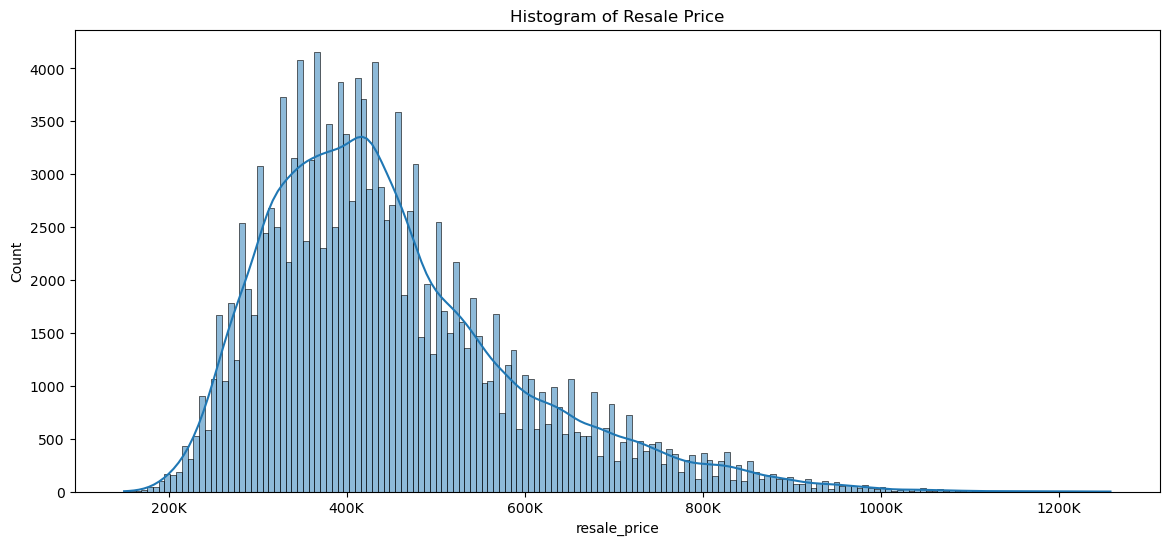

In [12]:
plt.figure(figsize=(14, 6))
sns.histplot(hdb_train_set['resale_price'], kde=True)
def hundreds_of_thousands(x, pos):
    return f'{int(x / 1000)}K'

formatter = mticker.FuncFormatter(hundreds_of_thousands)
plt.gca().xaxis.set_major_formatter(formatter)
plt.title('Histogram of Resale Price')
plt.show()

### Baseline Model

To start with our modeling, we will first create a simple baseline model.
For our initial baseline model, lets start with the following as features:
1. HDB Unit - floor_area_sqm

Our target variable to predict will be resale_price

In [13]:
# Setting target and baseline features
target = hdb_train_set['resale_price']
baseline_features = ['floor_area_sqm']

In [14]:
features = hdb_train_set[baseline_features]

##### Train-test Split with 30% test size and random_state 42

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.30, random_state=42)

In [16]:
# Instantiating the baseline model and fitting
baseline = LinearRegression()
baseline.fit(X_train, y_train)

LinearRegression()

In [17]:
y_pred = baseline.predict(X_test) # Using baseline to get the predictions

In [18]:
# Scoring the model
baseline_r2 = r2_score(y_test, y_pred)
baseline_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'The baseline R2 score is {baseline_r2:.3f}')
print(f'The baseline RMSE value is {baseline_rmse:.3f}')

The baseline R2 score is 0.431
The baseline RMSE value is 107444.372


With only one features (floor_area_sqm), our baseline model only scores at 0.431. This indicates that the model isn't really good, but we can establish that there is a linear relationship between the two variables.

## EDA and Visualization

Moving ahead, we will now consider the remaining features in the dataset.

### Feature categorization

As this is a very large dataset with 70+ columns and 150K+ records, it would be easier if we organize the columns into several broad categories.

The reasoning behind these categories and their choices was based on a mix of individual experiences, domain knowledge as well as some common understanding about real estate and the process of buying a home.

The categories are as below

1. **Transaction Details** - columns with past resale information


2. **Location Details** - columns such as town, block, lat, long etc. of the HDB block


3. **HDB Unit Info** - data about the actual HDB unit - flat_type, model, floor_area etc.


4. **HDB Utilities** - residential, commercial, market_hawker, carpark etc.


5. **Nearby Amenities** - distances from nearest hawker centres, malls etc.


6. **HDB Block Info** - data about the number of units, types of units sold and rented


7. **Transportation** - nearest MRT, bus stations, interchanges


8. **Education facilities** - distance from nearest primary, secondary school, affiliation etc.



To put this into a simple table, the categories will look as below:

### HDB Resale Dataset Categories

|Transaction Details|Location Details|HDB Unit|HDB Block Utilities|HDB Units sold/rented|Nearby Amenities|Transportation|Education|
|-|-|-|-|-|-|-|-|
| Tranc_YearMonth|town|flat_type|residential|1room_sold|Mall_Nearest_Distance| mrt_nearest_distance| pri_sch_nearest_distance|
| Tranc_Year| block| flat_model| commercial| 2room_sold| Mall_Within_500m| mrt_name| pri_sch_name|
| Tranc_Month| street_name| storey_range| market_hawker| 3room_sold| Mall_Within_1km| bus_interchange| vacancy|
|resale_price| address| floor_area_sqm| multistorey_carpark| 4room_sold| Mall_Within_2km| mrt_interchange| pri_sch_affiliation|
|| postal| floor_area_sqft| precinct_pavilion| 5room_sold| Hawker_Nearest_Distance| mrt_latitude| pri_sch_latitude|
|| Latitude| full_flat_type| total_dwelling_units| exec_sold| Hawker_Within_500m| mrt_longitude| pri_sch_longitude|
|| Longitude| lease_commence_date|| multigen_sold| Hawker_Within_1km| bus_stop_nearest_distance | sec_sch_nearest_dist|
|| planning_area| hdb_age|| studio_apartment_sold| Hawker_Within_2km| bus_stop_name| sec_sch_name|
||| max_floor_lvl|| 1room_rental| hawker_food_stalls| bus_stop_latitude | cutoff_point|
||| year_completed|| 2room_rental| hawker_market_stalls| bus_stop_longitude| affiliation|
||| mid_storey|| 3room_rental||| sec_sch_latitude|
||| lower|| other_room_rental||| sec_sch_longitude|
||| upper||||||
||| mid||||||



This table helps us to better identify and select features to build out a model.

To that end, we will analyze some columns to check for correlation towards the resale price

#### planning_area

Planning_area indicates the planning area for each resale flat transaction.

We can take a look at the top 7 areas where HDB flats were resold.

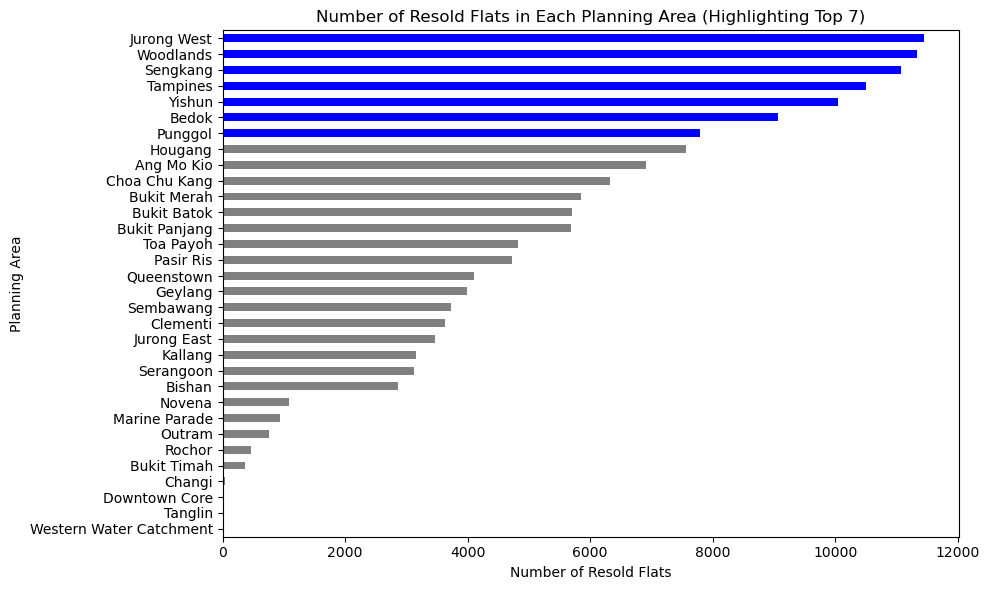

In [19]:
# Sort values
sorted_counts = hdb_train_set['planning_area'].value_counts().sort_values(ascending=True)

# Get top 7 values
top7_counts = sorted_counts[-7:]

# Colour list where all values are grey except for the top 7
colors = ['grey' if count not in top7_counts.values else 'blue' for count in sorted_counts]

plt.figure(figsize=(10, 6))
sorted_counts.plot(kind='barh', color=colors)

plt.title('Number of Resold Flats in Each Planning Area (Highlighting Top 7)')
plt.xlabel('Number of Resold Flats')
plt.ylabel('Planning Area')
plt.tight_layout()
plt.show()

From the above, we can see that Jurong West, Woodlands and Sengkang have seen the most number of resales in this dataset, with over 11,000 flats resold for each of them.

Changing our analysis a bit, lets look at a box plot for resale values across different planning areas.

<Figure size 1500x1000 with 0 Axes>

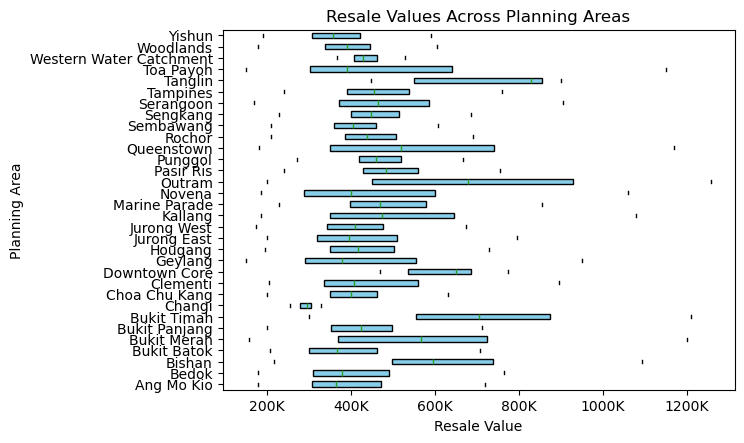

In [20]:
# Horizontal box plot without whiskers for resale values across different planning areas
plt.figure(figsize=(15, 10))
hdb_train_set.boxplot(column='resale_price', by='planning_area', grid=False, vert=False, patch_artist=True, 
           showfliers=False, whiskerprops=dict(visible=False), boxprops=dict(facecolor='skyblue'))

# Formatter for x-axis to show values in thousands (K)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

plt.title('Resale Values Across Planning Areas')
plt.suptitle('')
plt.xlabel('Resale Value')
plt.ylabel('Planning Area')
#plt.tight_layout()
plt.show()

Let's try and visualize the median prices across each planning area a bit differently.

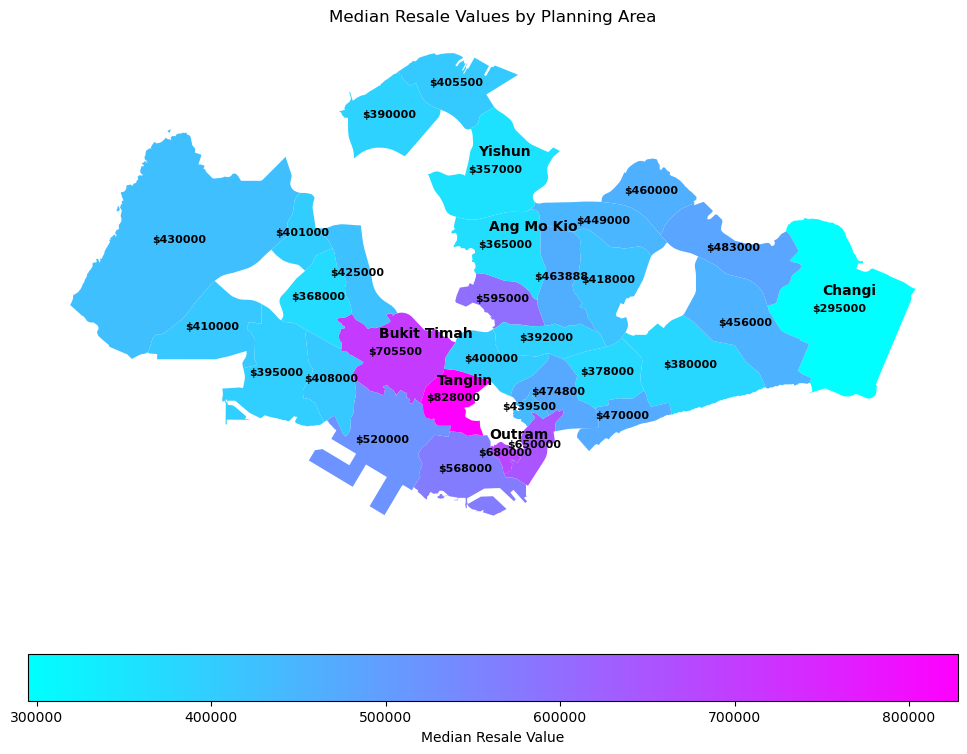

In [21]:
# Load planning areas GeoJSON file sourced from onemap.gov.sg
new_geojson_path = './datasets/district_and_planning_area.geojson'
with open(new_geojson_path, 'r') as file:
    geojson_data = json.load(file)

# Extract geometries and properties
data = {
    'planning_area': [],
    'geometry': []
}
for feature in geojson_data['features']:
    geometry = shape(feature['geometry'])
    if isinstance(geometry, (Polygon, MultiPolygon)):
        data['geometry'].append(geometry)
        data['planning_area'].append(feature['properties']['planning_area'])

# Create a DataFrame first
df_geo = pd.DataFrame(data)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df_geo, geometry='geometry')

# Calculate median resale values for each planning area
median_resale_values = hdb_train_set.groupby('planning_area')['resale_price'].median().reset_index()

# Merge GeoDataFrame with median resale values
merged_gdf = gdf.merge(median_resale_values, on='planning_area')
# Sort the merged GeoDataFrame by median resale price
sorted_gdf = merged_gdf.sort_values(by='resale_price')

# Select top 3 and bottom 3 planning areas
top_3 = sorted_gdf.head(3)
bottom_3 = sorted_gdf.tail(3)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged_gdf.plot(column='resale_price', cmap='cool', legend=True, ax=ax,
                legend_kwds={'label': "Median Resale Value",
                             'orientation': "horizontal"})

# Add annotations for median resale values
for idx, row in merged_gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(f"${int(row['resale_price'])}", xy=(centroid.x, centroid.y),
                 horizontalalignment='center', fontsize=8, color='black', weight='bold')

for idx, row in pd.concat([top_3, bottom_3]).iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(f"{row['planning_area']}", xy=(centroid.x, centroid.y),
                xytext=(-12, 12), textcoords="offset points",
                horizontalalignment='left', fontsize=10, color='black', weight='bold')    
# Hide the axis
ax.set_axis_off()
plt.title('Median Resale Values by Planning Area')
plt.show()


From the above plots, we can see that:
1. Based on the median sale prices, the planning areas and towns closer to the downtown area are among the most expensive
2. However, areas such as Toa Payoh and Kallang are above the 400K range
3. Finally, we're seeing more resale activity in non-mature estates such as Woodlands, Jurong West and Seng Kang - which is a bit unexpected.

Let's plot a few more features - this time against resale_price.

Features to plot: floor_area_sqm, hdb_age, Mall_Nearest_Distance

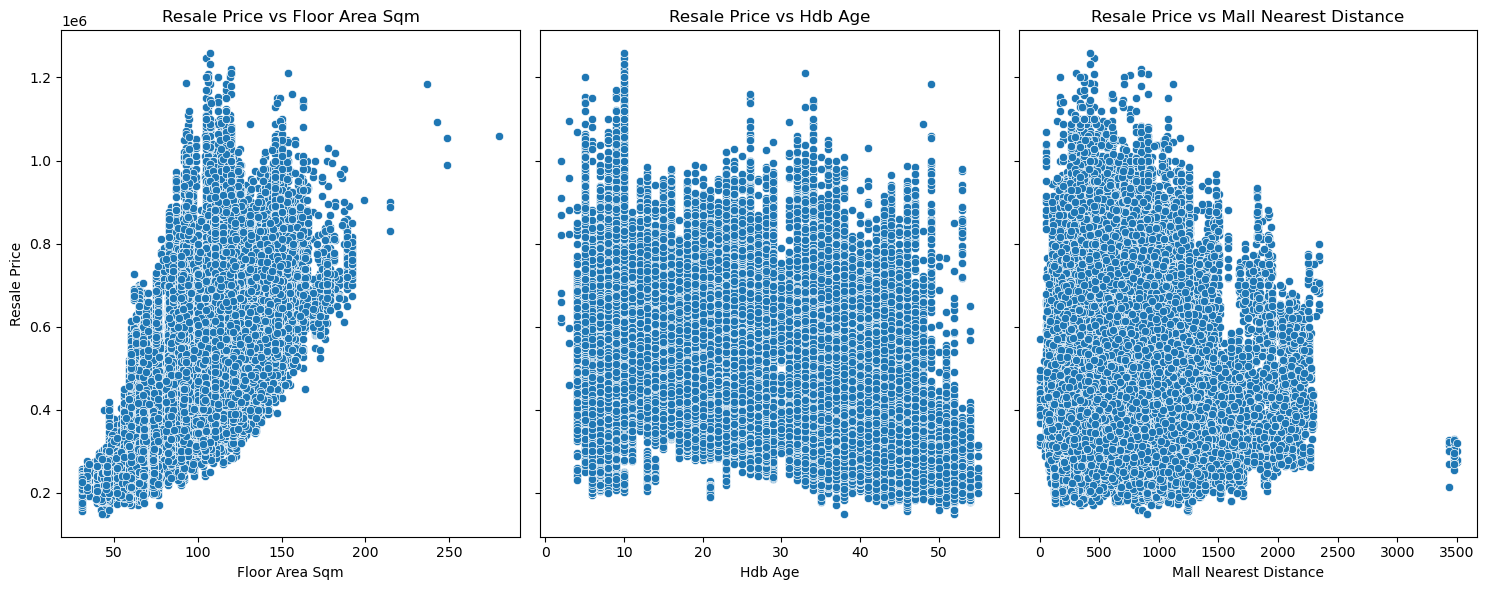

In [22]:
plot_cols = ['floor_area_sqm', 'hdb_age', 'Mall_Nearest_Distance']
fig, axes = plt.subplots(1, len(plot_cols), figsize=(5 * len(plot_cols), 6), sharey=True)

# Plot each column against 'resale_price'
for ax, column in zip(axes, plot_cols):
    sns.scatterplot(data=hdb_train_set, x=column, y='resale_price', ax=ax)
    ax.set_title(f'Resale Price vs {column.replace("_", " ").title()}')
    ax.set_xlabel(column.replace("_", " ").title())
    ax.set_ylabel('Resale Price')

plt.tight_layout()
plt.show()

From the above plots, we can see a bit of correlation with resale_price and floor_area_sqm - but not so much with the other metrics available.

The above visuals aren't very conclusive - however, we do know that floor area (which we used for our baseline model) and Planning Area (planning_area) are important and should be used in our modelling.

## Modelling

For our models, we will use initially start with Linear Regression, and verify if the features we select, improve upon the baseline model (which we created above).
With the Linear Regression model, we will then try to use Regularization methods - Lasso, Ridge and ElasticNet to verify and improve on the models if possible.

For validation and scoring, we will rely on R2 score and RMSE values. 

Increase in R2 scores and decrease in RMSE scores indicate better models.

Listing out the categories from before again

1. **Transaction Details** - columns with past resale information


2. **Location Details** - columns such as town, block, lat, long etc. of the HDB block


3. **HDB Unit Info** - data about the actual HDB unit - flat_type, model, floor_area etc.


4. **HDB Utilities** - residential, commercial, market_hawker, carpark etc.


5. **Nearby Amenities** - distances from nearest hawker centres, malls etc.


6. **HDB Block Info** - data about the number of units, types of units sold and rented


7. **Transportation** - nearest MRT, bus stations, interchanges


8. **Education facilities** - distance from nearest primary, secondary school, affiliation etc.

### HDB Resale Dataset Categories

|Transaction Details|Location Details|HDB Unit|HDB Block Utilities|HDB Units sold/rented|Nearby Amenities|Transportation|Education|
|-|-|-|-|-|-|-|-|
| Tranc_YearMonth|town|flat_type|residential|1room_sold|Mall_Nearest_Distance| mrt_nearest_distance| pri_sch_nearest_distance|
| Tranc_Year| block| flat_model| commercial| 2room_sold| Mall_Within_500m| mrt_name| pri_sch_name|
| Tranc_Month| street_name| storey_range| market_hawker| 3room_sold| Mall_Within_1km| bus_interchange| vacancy|
|resale_price| address| floor_area_sqm| multistorey_carpark| 4room_sold| Mall_Within_2km| mrt_interchange| pri_sch_affiliation|
|| postal| floor_area_sqft| precinct_pavilion| 5room_sold| Hawker_Nearest_Distance| mrt_latitude| pri_sch_latitude|
|| Latitude| full_flat_type| total_dwelling_units| exec_sold| Hawker_Within_500m| mrt_longitude| pri_sch_longitude|
|| Longitude| lease_commence_date|| multigen_sold| Hawker_Within_1km| bus_stop_nearest_distance | sec_sch_nearest_dist|
|| planning_area| hdb_age|| studio_apartment_sold| Hawker_Within_2km| bus_stop_name| sec_sch_name|
||| max_floor_lvl|| 1room_rental| hawker_food_stalls| bus_stop_latitude | cutoff_point|
||| year_completed|| 2room_rental| hawker_market_stalls| bus_stop_longitude| affiliation|
||| mid_storey|| 3room_rental||| sec_sch_latitude|
||| lower|| other_room_rental||| sec_sch_longitude|
||| upper||||||
||| mid||||||



### Feature Selection

For our models, we'll choose the features, which might appear to be the most relevant and affect the resale price. So, choosing from every category as below:

1. **Transaction Details** - *Tranc_Year*


2. **Location Details** - *planning_area*


3. **HDB Unit** - *flat_type, flat_model, floor_area_sqm, full_flat_type, hdb_age, max_floor_lvl, mid_storey*


4. **HDB Block Utilities** - *commercial, market_hawker, multistorey_carpark, precinct_pavilion, total_dwelling_units*


5. **HDB Units sold / rented** - none


6. **Nearby Amenities** - *Mall_Nearest_Distance, Hawker_Nearest_Distance*


7. **Transportation** - *mrt_nearest_distance, bus_interchange, mrt_interchange, bus_stop_nearest_distance*


8. **Education** - *pri_sch_nearest_distance, affiliation, sec_sch_nearest_dist*

In [23]:
# Saving the selected columns to a list
cols_of_interest = ['Tranc_Year',
                    'planning_area', 
                    'flat_type', 'flat_model','floor_area_sqm', 'hdb_age', 'max_floor_lvl', 'mid_storey',
                    'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion', 'total_dwelling_units',
                    'Mall_Nearest_Distance', 'Hawker_Nearest_Distance',
                    'mrt_nearest_distance', 'bus_interchange', 'mrt_interchange', 'bus_stop_nearest_distance', 
                    'pri_sch_nearest_distance', 'affiliation', 'sec_sch_nearest_dist']
raw_df = hdb_train_set[cols_of_interest]
raw_df.head(10)

,Tranc_Year,planning_area,flat_type,flat_model,floor_area_sqm,hdb_age,max_floor_lvl,mid_storey,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,affiliation,sec_sch_nearest_dist
0,2016,Kallang,4 ROOM,Model A,90.00,15,25,11,N,N,N,N,142,"1,094.09",154.75,330.08,0,0,29.43,"1,138.63",0,"1,138.63"
1,2012,Bishan,5 ROOM,Improved,130.00,34,9,8,N,N,N,N,112,866.94,640.15,903.66,1,1,58.21,415.61,0,447.89
2,2013,Bukit Batok,EXECUTIVE,Apartment,144.00,24,16,14,N,N,N,N,90,"1,459.58","1,762.08","1,334.25",1,0,214.75,498.85,0,180.07
3,2012,Bishan,4 ROOM,Model A,103.00,29,11,3,Y,N,N,N,75,950.18,726.22,907.45,1,1,43.40,389.52,1,389.52
4,2017,Yishun,4 ROOM,Simplified,83.00,34,4,2,N,N,N,N,48,729.77,"1,540.15",412.34,0,0,129.42,401.20,0,312.03
5,2013,Geylang,3 ROOM,Improved,65.00,46,12,8,Y,N,N,N,193,684.00,148.42,678.29,0,1,229.68,594.13,0,608.84
6,2018,Hougang,5 ROOM,Improved,120.00,34,17,8,N,N,N,N,64,490.26,516.98,"1,370.65",0,0,46.57,331.67,0,294.83
7,2012,Bedok,3 ROOM,New Generation,68.00,41,12,8,Y,N,N,N,132,"1,749.15",734.25,291.63,0,0,71.97,365.79,0,835.01
8,2020,Bishan,5 ROOM,Improved,125.00,32,25,11,N,N,N,N,92,445.72,"1,032.85","1,584.10",0,0,105.18,398.37,0,866.36
9,2014,Sengkang,5 ROOM,Improved,110.00,20,17,11,N,N,N,N,96,853.38,"1,743.70","1,055.00",1,1,89.35,94.34,0,458.53


In [24]:
# Using a helper function to get a quick snapshot of the raw dataset
summarize_dataframe(raw_df)

,Column Name,Unique Values,Number of Unique Values,Data Type
0,Tranc_Year,"[2016, 2012, 2013, 2017, 2018, 2020, 2014, 201...",10,int64
1,planning_area,"[Kallang, Bishan, Bukit Batok, Yishun, Geylang...",32,object
2,flat_type,"[4 ROOM, 5 ROOM, EXECUTIVE, 3 ROOM, 2 ROOM, 1 ...",7,object
3,flat_model,"[Model A, Improved, Apartment, Simplified, New...",20,object
4,floor_area_sqm,"[90.0, 130.0, 144.0, 103.0, 83.0, 65.0, 120.0,...",169,float64
5,hdb_age,"[15, 34, 24, 29, 46, 41, 32, 20, 12, 36, 8, 19...",54,int64
6,max_floor_lvl,"[25, 9, 16, 11, 4, 12, 17, 13, 36, 15, 24, 26,...",41,int64
7,mid_storey,"[11, 8, 14, 3, 2, 29, 20, 5, 17, 23, 18, 35, 2...",22,int64
8,commercial,"[N, Y]",2,object
9,market_hawker,"[N, Y]",2,object


In [25]:
# Assigning to a new dataframe for the actual modelling
linreg_df = raw_df

### Preprocessing before Train-test split

From the summary, we can see that there are a few object columns with binary Y/N values. Also, we know that at least one column has some missing values.
Running preprocessing steps as below:
1. Replace binary Y / N with 1 / 0 values respectively
2. Checking for missing values and drop or impute as needed
3. Replacing object / string values with get_dummies

#### 1. Replacing Y/N values

In [26]:
linreg_df.replace({'Y': 1, 'N': 0}, inplace=True)

In [27]:
# Adding the target column before handling missing values
linreg_df = pd.concat([linreg_df, target], axis=1)
linreg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Tranc_Year                 150634 non-null  int64  
 1   planning_area              150634 non-null  object 
 2   flat_type                  150634 non-null  object 
 3   flat_model                 150634 non-null  object 
 4   floor_area_sqm             150634 non-null  float64
 5   hdb_age                    150634 non-null  int64  
 6   max_floor_lvl              150634 non-null  int64  
 7   mid_storey                 150634 non-null  int64  
 8   commercial                 150634 non-null  int64  
 9   market_hawker              150634 non-null  int64  
 10  multistorey_carpark        150634 non-null  int64  
 11  precinct_pavilion          150634 non-null  int64  
 12  total_dwelling_units       150634 non-null  int64  
 13  Mall_Nearest_Distance      14

#### 2. Handling missing values

In [28]:
# Listing columns with empty rows and their counts
empty_rows = linreg_df.isnull().sum()
empty_rows[empty_rows > 0]

Mall_Nearest_Distance    829
dtype: int64

As 829 rows is barely more than 0.5% of the dataset, it is tempting to drop these records completely.
However, instead of dropping them, we will impute those values to the median of Mall_nearest_Distance. The reasoning for this is two-fold:
- setting a median value allows us to set an equitable level of bias for these records
- the Kaggle dataset also may have similar missing values, and as part of the submission, we cannot drop rows there

In any case, as the imputed rows number less than 1000, we don't expect the model to be adversely impacted.

In [29]:
linreg_df['Mall_Nearest_Distance'].describe()

count   149,805.00
mean        664.24
std         368.74
min           0.00
25%         391.47
50%         602.82
75%         868.82
max       3,496.40
Name: Mall_Nearest_Distance, dtype: float64

In [30]:
mall_median_dist = linreg_df['Mall_Nearest_Distance'].median()
print(f'The mall median distance is {mall_median_dist:.3f}')

The mall median distance is 602.818


In [31]:
# Using fillna() with the median just calculated
linreg_df['Mall_Nearest_Distance'] = linreg_df['Mall_Nearest_Distance'].fillna(mall_median_dist)
linreg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Tranc_Year                 150634 non-null  int64  
 1   planning_area              150634 non-null  object 
 2   flat_type                  150634 non-null  object 
 3   flat_model                 150634 non-null  object 
 4   floor_area_sqm             150634 non-null  float64
 5   hdb_age                    150634 non-null  int64  
 6   max_floor_lvl              150634 non-null  int64  
 7   mid_storey                 150634 non-null  int64  
 8   commercial                 150634 non-null  int64  
 9   market_hawker              150634 non-null  int64  
 10  multistorey_carpark        150634 non-null  int64  
 11  precinct_pavilion          150634 non-null  int64  
 12  total_dwelling_units       150634 non-null  int64  
 13  Mall_Nearest_Distance      15

In [32]:
# Checking for empty rows again
empty_rows = linreg_df.isna().sum()
empty_rows[empty_rows > 0]

Series([], dtype: int64)

There are no missing values. Moving to the next step..

#### 3. Replacing object / string values with numeric values i.e. One-Hot Encoding

For One-hot encoding, we'll use the pandas.get_dummies method

In [33]:
linreg_df = pd.get_dummies(linreg_df, drop_first=True)
linreg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 76 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Tranc_Year                             150634 non-null  int64  
 1   floor_area_sqm                         150634 non-null  float64
 2   hdb_age                                150634 non-null  int64  
 3   max_floor_lvl                          150634 non-null  int64  
 4   mid_storey                             150634 non-null  int64  
 5   commercial                             150634 non-null  int64  
 6   market_hawker                          150634 non-null  int64  
 7   multistorey_carpark                    150634 non-null  int64  
 8   precinct_pavilion                      150634 non-null  int64  
 9   total_dwelling_units                   150634 non-null  int64  
 10  Mall_Nearest_Distance                  150634 non-null  

#### Assigning Target and Features

In [34]:
X = linreg_df.drop(columns=['resale_price'])

In [35]:
y = linreg_df['resale_price']

#### Train-Test Split with Test sample at 30% and Random state at 42

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

#### Feature Scaling

Due to the varying scales across all variables, we decided to use Sklearn's StandardScaler() to normalize the features. This will be applied to both the Train and Test feature sets.

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.fit_transform(X_test)

In [38]:
# Instantiating the model and fitting to the Scaled Train set
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

LinearRegression()

In [39]:
# Generating the predicted values, and scoring the model
y_pred = linreg.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

In [40]:
print(f'R2 Score for Linear Regression: {r2:.3f}')
print(f'RMSE based on Linear Regression model: ${rmse:.3f}')

R2 Score for Linear Regression: 0.884
RMSE based on Linear Regression model: $48515.277


#### Cross-validation (5-fold)

In [41]:
lr_cv_scores = cross_val_score(linreg, X_test_scaled, y_test, cv=5)
print(f'List of r2 scores from CV: {lr_cv_scores}')
print('Mean linear regression CV Score =', np.mean(lr_cv_scores).round(3))

List of r2 scores from CV: [0.88313795 0.88378846 0.88826577 0.88196814 0.88304039]
Mean linear regression CV Score = 0.884


Our Linear Regression model has a far better r2 score (0.884) over the baseline model (0.431). 

This indicates that the Linear Regression model performs better at predicting the resale prices for the HDB dataset.

### Regularization

To try and improve the model where possible, we'll apply L1 (Lasso) and L2 (Ridge) regularization. By improvement, we are looking to increase the R2 score and / or reduce the RMSE value if feasible.

#### Lasso Regularization

In [42]:
# Lasso instantiation and identifying best-fit hyperparameters
lasso = Lasso()
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]} # Setting a conservative alpha value range
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5) # Using GridSearchCV to combine GridSearch and cross validation
lasso_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]})

In [43]:
# Identifying best alpha and estimator and scoring R2 and RMSE
best_lasso = lasso_grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_scaled)
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)

In [44]:
print(f'Best Lasso Alpha: {lasso_grid.best_params_["alpha"]}')
print(f'Lasso R²: {r2_lasso:.3f}')
print(f'Lasso RMSE: {rmse_lasso:.3f}')

Best Lasso Alpha: 1
Lasso R²: 0.884
Lasso RMSE: 48516.654


#### Ridge Regularization

In [45]:
# Ridge instantiation and identifying best-fit hyperparameters
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5)
ridge_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]})

In [46]:
# Best Ridge Model and Scoring R2 and RMSE
best_ridge = ridge_grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)

In [47]:
print(f'Best Ridge Alpha: {ridge_grid.best_params_["alpha"]}')
print(f'Ridge R²: {r2_ridge:.3f}')
print(f'Ridge RMSE: {rmse_ridge:.3f}')

Best Ridge Alpha: 10
Ridge R²: 0.884
Ridge RMSE: 48516.368


#### ElasticNet Regularization

ElasticNet Regularization combines both Ridge and Lasso regularization, and uses 2 hyperparameters - alpha and l1_ratio. We've chosen standard conservative values for both of these.

In [48]:
# ElasticNet Regularization instantiation and Model fitting
elasticnet = ElasticNet()
elasticnet_params = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Mixing parameter, with 0 <= l1_ratio <= 1
}
elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv=5)
elasticnet_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]})

In [49]:
# Best ElasticNet Model and Scoring R2 and RMSE
best_elasticnet = elasticnet_grid.best_estimator_
y_pred_elasticnet = best_elasticnet.predict(X_test_scaled)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)
rmse_elasticnet = mean_squared_error(y_test, y_pred_elasticnet, squared=False)

In [50]:
print(f'Best ElasticNet Params: {elasticnet_grid.best_params_}')
print(f'ElasticNet R²: {r2_elasticnet}')
print(f'ElasticNet RMSE: {rmse_elasticnet}')

Best ElasticNet Params: {'alpha': 0.01, 'l1_ratio': 0.9}
ElasticNet R²: 0.8840245243716439
ElasticNet RMSE: 48515.308745570124


Here's a quick table with all the models and their scores

In [51]:
scores_dict = {
    'Models': ['Baseline', 'Linear Regression', 'Lasso', 'Ridge', 'ElasticNet'],
    'R2': [baseline_r2, r2, r2_lasso, r2_ridge, r2_elasticnet],
    'RMSE': [baseline_rmse, rmse, rmse_lasso, rmse_ridge, rmse_elasticnet]
}
score_table = pd.DataFrame(scores_dict)
print(score_table)

              Models   R2       RMSE
0           Baseline 0.43 107,444.37
1  Linear Regression 0.88  48,515.28
2              Lasso 0.88  48,516.65
3              Ridge 0.88  48,516.37
4         ElasticNet 0.88  48,515.31


From the above table, it seems the Lasso model returns the lower RMSE, but R2 scores stay consistent across all models and regularizations.
Therefore, we will keep the best fit model as the plain vanilla Linear Regression model.

## Kaggle Challenge

We'll use the Linear Regression model for the Kaggle submission

In [52]:
# Filtering the test set to only show the selected feature set
kaggle_df = hdb_test_set[cols_of_interest]
kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Tranc_Year                 16737 non-null  int64  
 1   planning_area              16737 non-null  object 
 2   flat_type                  16737 non-null  object 
 3   flat_model                 16737 non-null  object 
 4   floor_area_sqm             16737 non-null  float64
 5   hdb_age                    16737 non-null  int64  
 6   max_floor_lvl              16737 non-null  int64  
 7   mid_storey                 16737 non-null  int64  
 8   commercial                 16737 non-null  object 
 9   market_hawker              16737 non-null  object 
 10  multistorey_carpark        16737 non-null  object 
 11  precinct_pavilion          16737 non-null  object 
 12  total_dwelling_units       16737 non-null  int64  
 13  Mall_Nearest_Distance      16653 non-null  flo

### Kaggle Preprocessing
Applying same preprocessing steps as the Linear Regression set
1. Imputing missing values
2. Replacing Y/N values with 1 / 0
3. One Hot encoding

#### 1. Imputing missing values

In [53]:
kaggle_df['Mall_Nearest_Distance'] = kaggle_df['Mall_Nearest_Distance'].fillna(mall_median_dist)
kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Tranc_Year                 16737 non-null  int64  
 1   planning_area              16737 non-null  object 
 2   flat_type                  16737 non-null  object 
 3   flat_model                 16737 non-null  object 
 4   floor_area_sqm             16737 non-null  float64
 5   hdb_age                    16737 non-null  int64  
 6   max_floor_lvl              16737 non-null  int64  
 7   mid_storey                 16737 non-null  int64  
 8   commercial                 16737 non-null  object 
 9   market_hawker              16737 non-null  object 
 10  multistorey_carpark        16737 non-null  object 
 11  precinct_pavilion          16737 non-null  object 
 12  total_dwelling_units       16737 non-null  int64  
 13  Mall_Nearest_Distance      16737 non-null  flo

In [54]:
summarize_dataframe(kaggle_df)

,Column Name,Unique Values,Number of Unique Values,Data Type
0,Tranc_Year,"[2012, 2019, 2013, 2017, 2016, 2020, 2018, 201...",10,int64
1,planning_area,"[Yishun, Jurong West, Ang Mo Kio, Woodlands, B...",32,object
2,flat_type,"[4 ROOM, 5 ROOM, 3 ROOM, EXECUTIVE, 2 ROOM, 1 ...",7,object
3,flat_model,"[Simplified, Premium Apartment, New Generation...",19,object
4,floor_area_sqm,"[84.0, 112.0, 68.0, 97.0, 103.0, 65.0, 73.0, 6...",153,float64
5,hdb_age,"[34, 13, 41, 42, 36, 39, 33, 5, 6, 35, 18, 7, ...",53,int64
6,max_floor_lvl,"[12, 14, 25, 15, 10, 17, 18, 16, 27, 13, 4, 11...",40,int64
7,mid_storey,"[8, 5, 2, 17, 11, 14, 13, 23, 3, 26, 32, 20, 3...",21,int64
8,commercial,"[Y, N]",2,object
9,market_hawker,[N],1,object


Comparing the Kaggle dataset, we notice that the flat_model variable has one unique value less (19) as compared to the train dataset(20).

We will handle this by reindexing after one-hot encoding.

#### 2. Replacing Y/N strings with 1/0

In [55]:
kaggle_df.replace({'Y': 1, 'N': 0}, inplace=True)

#### 3. One-hot encoding using pandas get_dummies

In [56]:
kaggle_df = pd.get_dummies(kaggle_df, drop_first=True)

We'll reindex the dataframe columns, to match the columns from the features dataset, and fill out the missing column with zeroes

In [57]:
kaggle_df = kaggle_df.reindex(columns=X.columns, fill_value=0)
kaggle_df.shape

(16737, 75)

#### Using StandardScaler() for Normalizing and Linear Regression to Predict

In [58]:
kaggle_df_scaled = scaler.fit_transform(kaggle_df)
kaggle_pred = linreg.predict(kaggle_df_scaled)
kaggle_pred

array([366924.9161942 , 508617.57832241, 355756.6066245 , ...,
       392392.83030592, 483125.7911942 , 359393.01780592])

### Adding the prediction to the Kaggle test

In [59]:
hdb_test_set['resale_price'] = kaggle_pred
summarize_dataframe(hdb_test_set)

,Column Name,Unique Values,Number of Unique Values,Data Type
0,id,"[114982, 95653, 40303, 109506, 100149, 7610, 6...",16737,int64
1,Tranc_YearMonth,"[2012-11, 2019-08, 2013-10, 2017-10, 2016-08, ...",110,object
2,town,"[YISHUN, JURONG WEST, ANG MO KIO, WOODLANDS, B...",26,object
3,flat_type,"[4 ROOM, 5 ROOM, 3 ROOM, EXECUTIVE, 2 ROOM, 1 ...",7,object
4,block,"[173, 986C, 534, 29, 170, 27, 840, 808A, 334A,...",2248,object
...,...,...,...,...
73,cutoff_point,"[218, 199, 245, 188, 223, 249, 208, 189, 203, ...",54,int64
74,affiliation,"[0, 1]",2,int64
75,sec_sch_latitude,"[1.436235146, 1.335256345, 1.374242189, 1.4391...",134,float64
76,sec_sch_longitude,"[103.8299865, 103.7020981, 103.85143, 103.7744...",134,float64


### Kaggle Submission

In [60]:
submission_df = hdb_test_set[['id','resale_price']]
submission_df

,id,resale_price
0,114982,"366,924.92"
1,95653,"508,617.58"
2,40303,"355,756.61"
3,109506,"260,552.79"
4,100149,"478,436.58"
...,...,...
16732,23347,"366,217.86"
16733,54003,"509,653.02"
16734,128921,"392,392.83"
16735,69352,"483,125.79"


In [61]:
# Preparing for submission - renaming columns and setting float values to int
submission_df.rename(columns={'id':'Id','resale_price':'Predicted'}, inplace=True)
submission_df['Predicted'] = submission_df['Predicted'].astype(int)
submission_df.head()

,Id,Predicted
0,114982,366924
1,95653,508617
2,40303,355756
3,109506,260552
4,100149,478436


In [62]:
submission_df.to_csv('./datasets/submission.csv', index=False)